### MetNoulli Latent Hazard Model

For patient $i$, site $s$, and discrete time $t$:

1. **Baseline logit** (empirical prevalence per site/time):
   $$\text{base}_s(t) = \log \frac{p_s(t)}{1 - p_s(t)}$$

2. **Latent pathway weights** (softmax over pathway scores):
   $$\lambda_{i,k}(t) \;\Rightarrow\; \theta_{i,k}(t) = \frac{\exp(\lambda_{i,k}(t))}{\sum_{k'} \exp(\lambda_{i,k'}(t))}$$

3. **Pathway profiles / interaction offsets**:
   $$\phi_{k,s}(t) \text{ (time-varying deviation)}, \qquad \psi_{s,m} \text{ (optional site-to-site effect)}$$

4. **Logit of metastasis hazard**:
   $$\eta_{i,s}(t) = \text{base}_s(t) + \sum_{k=1}^{K} \theta_{i,k}(t)\,\phi_{k,s}(t) + \Gamma_s \cdot G_i + \psi_s \cdot m_i(t)$$

5. **Probability of new metastasis**:
   $$\pi_{i,s}(t) = \sigma(\eta_{i,s}(t)) = \frac{1}{1 + e^{-\eta_{i,s}(t)}}$$

Here $G_i$ are patient covariates, $m_i(t)$ indicates existing metastases, and the latent factors $(\theta, \phi)$ capture shared metastatic pathways across sites and time.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


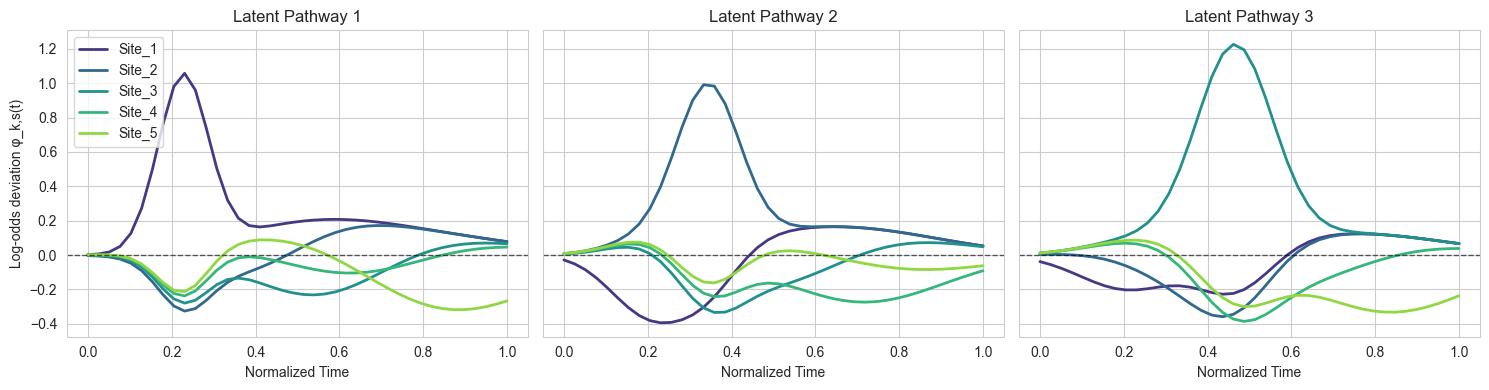

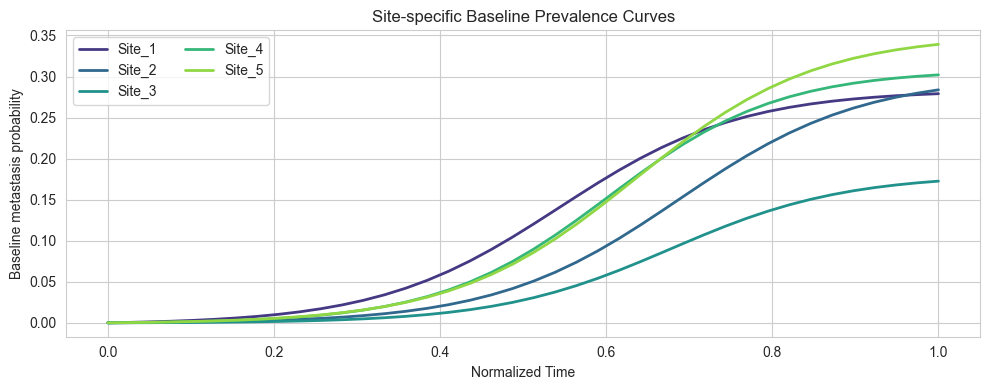

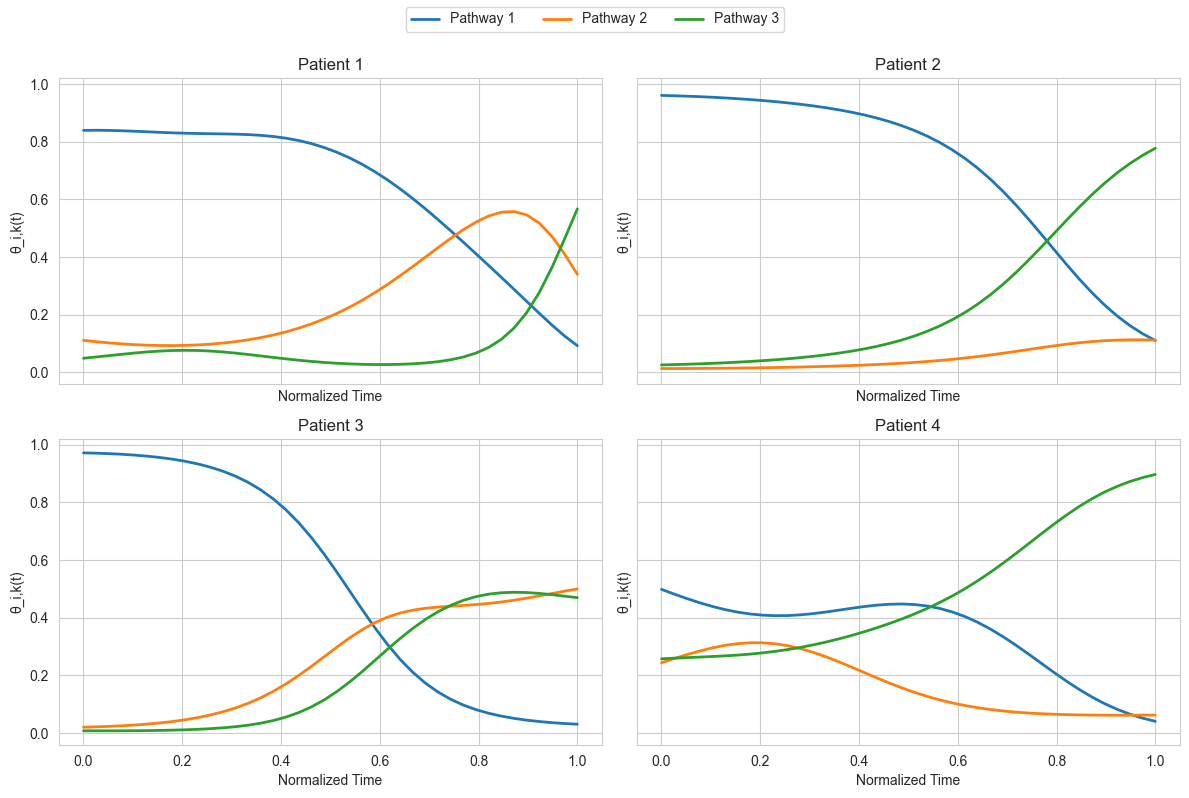

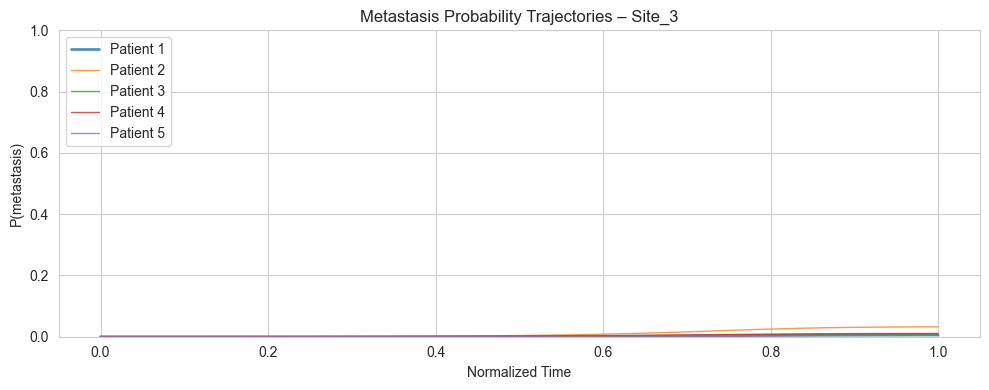

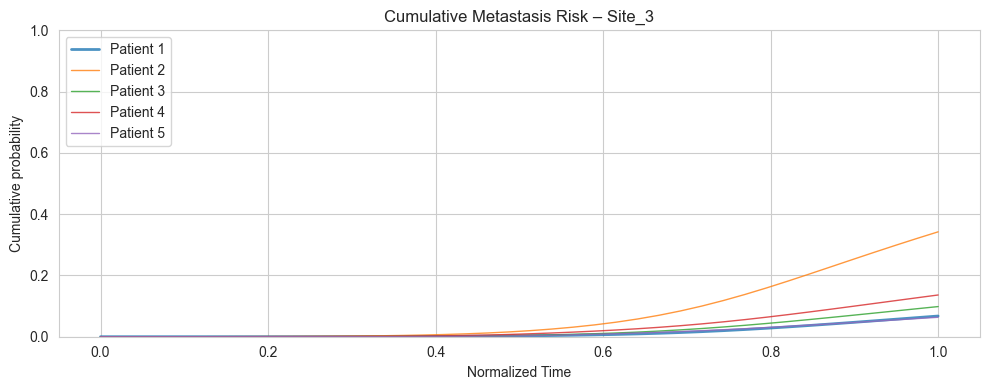

In [17]:
%load_ext autoreload
%autoreload 2
from metnoulli_latent_simulation import (
    LatentPathwaySimulationConfig,
    simulate_metastasis_probabilities,
    plot_simulation_outputs,
    run_demo,
)

# 1. Simulate latent metastasis dataset
config = LatentPathwaySimulationConfig(
    n_patients=300,
    n_sites=5,
    n_pathways=3,
    n_time=40,
)

simulation = simulate_metastasis_probabilities(config)
plot_simulation_outputs(simulation)

### From Simulation to Fit

We can now turn the simulated probabilities into a synthetic dataset, warm-start a MetNoulli-style model, and sketch the training loop. The cells below provide a scaffold you can adapt once the full model class is in place.


In [18]:
from dataclasses import dataclass
from typing import Dict, Any

import numpy as np
from sklearn.cluster import SpectralClustering

@dataclass
class PreparedDataset:
    Y: np.ndarray
    event_times: np.ndarray
    covariates: np.ndarray
    baseline_logit: np.ndarray
    sites: np.ndarray
    time: np.ndarray


def prepare_simulated_dataset(simulation: Dict[str, np.ndarray], rng_seed: int = 123) -> PreparedDataset:
    """Sample metastasis indicators and event times from the simulator output."""
    rng = np.random.default_rng(rng_seed)

    probs = simulation["probs"]  # (patients, sites, time)
    Y = rng.binomial(1, probs)

    # First time a metastasis appears per patient/site; fallback to censoring at final bin
    event_times = np.full(probs.shape[:2], probs.shape[2] - 1, dtype=int)
    for i in range(probs.shape[0]):
        for s in range(probs.shape[1]):
            met_indices = np.where(Y[i, s] == 1)[0]
            if met_indices.size > 0:
                event_times[i, s] = met_indices[0]

    return PreparedDataset(
        Y=Y,
        event_times=event_times,
        covariates=simulation["covariates"],
        baseline_logit=np.log(simulation["baseline_prob"] / (1 - simulation["baseline_prob"])),
        sites=simulation["sites"],
        time=simulation["time"],
    )


def hot_start_from_counts(dataset: PreparedDataset, n_pathways: int) -> Dict[str, Any]:
    """Derive ψ and cluster assignments from simulated counts (Noulli-style contrast)."""
    Y_avg = dataset.Y.mean(axis=0)  # (sites, time)
    similarity = np.corrcoef(Y_avg)
    similarity = np.nan_to_num(similarity, nan=0.0)
    affinity = (similarity + 1.0) / 2.0

    spectral = SpectralClustering(
        n_clusters=n_pathways,
        affinity="precomputed",
        assign_labels="kmeans",
        random_state=1,
    )
    clusters = spectral.fit_predict(affinity)

    psi_config = {
        "in_cluster": 1.0,
        "out_cluster": -2.0,
        "noise_in": 0.1,
        "noise_out": 0.01,
    }

    rng = np.random.default_rng(42)
    psi_init = np.zeros((n_pathways, dataset.sites.size))
    for k in range(n_pathways):
        membership = clusters == k
        psi_init[k, membership] = psi_config["in_cluster"] + psi_config["noise_in"] * rng.standard_normal(
            membership.sum()
        )
        psi_init[k, ~membership] = psi_config["out_cluster"] + psi_config["noise_out"] * rng.standard_normal(
            (~membership).sum()
        )

    return {"clusters": clusters, "psi_init": psi_init}


def train_metnoulli_stub(dataset: PreparedDataset, hot_start: Dict[str, Any]) -> None:
    """Placeholder for the actual MetNoulli training loop with explanatory comments."""
    print("Step 1: Instantiate your MetNoulli model class with dataset dimensions.")
    print("Step 2: Load hot-start parameters (ψ, baseline logits, covariates).")
    print("Step 3: Build tensors (Y, event_times, covariates) and send to device.")
    print("Step 4: Run Adam loop: forward → loss → backward → optimizer.step().")
    print("Step 5: Monitor losses, calibration, trajectory plots.")


In [19]:
# 3. Train MetNoulli latent model
import os
import sys

import torch

sys.path.append("/Users/sarahurbut/metnoulli/src")  # ensure module import path

# 2. Sample metastasis indicators and hot-start ψ
hot_start = None

dataset = prepare_simulated_dataset(simulation)
hot_start = hot_start_from_counts(dataset, n_pathways=config.n_pathways)

print("Prepared dataset:")
print(f"  Y shape: {dataset.Y.shape}")
print(f"  Event times shape: {dataset.event_times.shape}")
print(f"  Baseline logit shape: {dataset.baseline_logit.shape}")
print(f"  Hot-start ψ shape: {hot_start['psi_init'].shape}")



from metnoulli_latent_model import (
    MetNoulliLatentModel,
    MetNoulliBatch,
    train_metnoulli_model,
)

baseline_logit_tensor = torch.tensor(dataset.baseline_logit, dtype=torch.float32)
covariate_tensor = torch.tensor(dataset.covariates, dtype=torch.float32)

model = MetNoulliLatentModel(
    n_patients=dataset.Y.shape[0],
    n_sites=dataset.Y.shape[1],
    n_time=dataset.Y.shape[2],
    n_pathways=config.n_pathways,
    n_covariates=covariate_tensor.shape[1],
    baseline_logit=baseline_logit_tensor,
    covariates=covariate_tensor,
    psi_init=hot_start["psi_init"],
)

batch = MetNoulliBatch(
    Y=torch.tensor(dataset.Y, dtype=torch.float32),
    event_times=torch.tensor(dataset.event_times, dtype=torch.long),
    covariates=covariate_tensor,
)

results = train_metnoulli_model(model, batch, n_epochs=1000, learning_rate=5e-3)
print("Final training loss:", results["losses"][-1])


Prepared dataset:
  Y shape: (300, 5, 40)
  Event times shape: (300, 5)
  Baseline logit shape: (5, 40)
  Hot-start ψ shape: (3, 5)
Epoch 001 | Loss 12.2783
Epoch 025 | Loss 10.4206
Epoch 050 | Loss 9.1415
Epoch 075 | Loss 8.2175
Epoch 100 | Loss 7.4549
Epoch 125 | Loss 6.7641
Epoch 150 | Loss 6.1196
Epoch 175 | Loss 5.5315
Epoch 200 | Loss 5.0202
Epoch 225 | Loss 4.5982
Epoch 250 | Loss 4.2634
Epoch 275 | Loss 4.0031
Epoch 300 | Loss 3.8007
Epoch 325 | Loss 3.6410
Epoch 350 | Loss 3.5121
Epoch 375 | Loss 3.4053
Epoch 400 | Loss 3.3143
Epoch 425 | Loss 3.2351
Epoch 450 | Loss 3.1645
Epoch 475 | Loss 3.1005
Epoch 500 | Loss 3.0415
Epoch 525 | Loss 2.9865
Epoch 550 | Loss 2.9347
Epoch 575 | Loss 2.8855
Epoch 600 | Loss 2.8384
Epoch 625 | Loss 2.7930
Epoch 650 | Loss 2.7489
Epoch 675 | Loss 2.7059
Epoch 700 | Loss 2.6637
Epoch 725 | Loss 2.6221
Epoch 750 | Loss 2.5808
Epoch 775 | Loss 2.5398
Epoch 800 | Loss 2.4989
Epoch 825 | Loss 2.4581
Epoch 850 | Loss 2.4173
Epoch 875 | Loss 2.3762
Ep

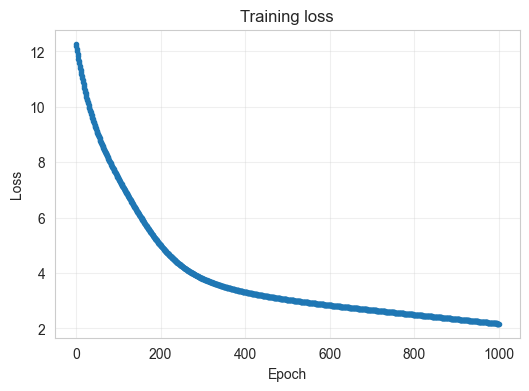

In [26]:

plt.figure(figsize=(6, 4))
plt.plot(results["losses"], marker="o", markersize=3, linewidth=1)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()


# Visualize fit

In [21]:
Y_obs = dataset.Y                    # binary events (N, D, T)
event_times = dataset.event_times    # first-hit indices
true_probs = simulation["probs"]     # simulator ground-truth hazards
pred_probs = results["probs"]     

In [22]:
at_risk = np.ones_like(Y_obs, dtype=bool)
N, D, T = Y_obs.shape
for n in range(N):
    for d in range(D):
        hits = np.where(Y_obs[n, d] == 1)[0]
        if hits.size > 0:
            at_risk[n, d, hits[0] + 1 :] = False  # only before/at first event

In [23]:
valid_pred = pred_probs[at_risk]
valid_true = true_probs[at_risk]
cal_factor = valid_true.mean() / (valid_pred.mean() + 1e-12)
pred_calibrated = np.clip(pred_probs * cal_factor, 0.0, 1.0)

from sklearn.metrics import confusion_matrix

threshold = 0.1  # or any cutoff you prefer
y_true = Y_obs[at_risk].astype(int)
y_pred = (pred_calibrated[at_risk] >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)  # [[TN, FP],[FN, TP]]
print(cm)

[[53588   333]
 [   20   532]]


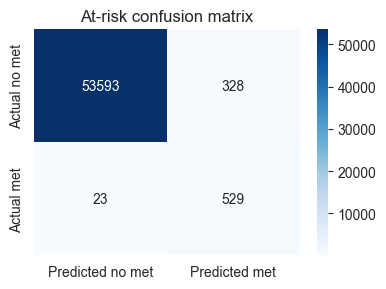

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted no met", "Predicted met"],
            yticklabels=["Actual no met", "Actual met"])
plt.title("At-risk confusion matrix")
plt.tight_layout()
plt.show()

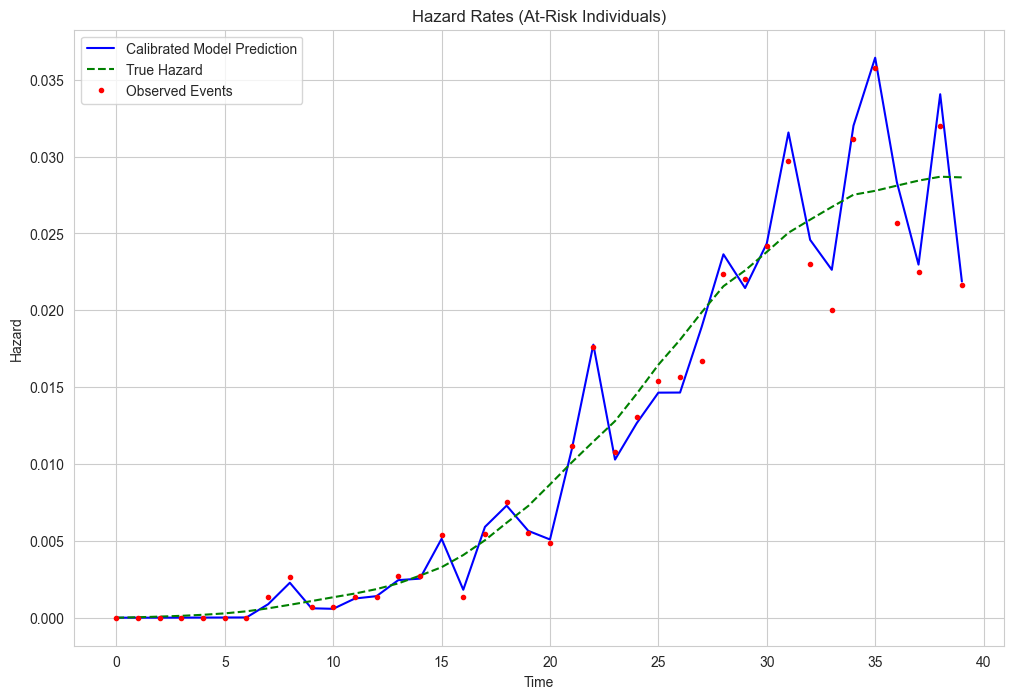

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hazard_comparison(Y, pi_pred, true_pi, calibration_factor=1.0):
    N, D, T = Y.shape

    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            hits = np.where(Y[n, d] == 1)[0]
            if hits.size > 0:
                at_risk[n, d, hits[0] + 1 :] = False

    calibrated_pred = np.clip(pi_pred * calibration_factor, 0.0, 1.0)

    mean_pred, mean_true, mean_obs = [], [], []
    for t in range(T):
        mask_t = at_risk[:, :, t]
        if mask_t.any():
            mean_pred.append(calibrated_pred[:, :, t][mask_t].mean())
            mean_true.append(true_pi[:, :, t][mask_t].mean())
            mean_obs.append(Y[:, :, t][mask_t].mean())

    plt.figure(figsize=(12, 8))
    plt.plot(mean_pred, "b-", label="Calibrated Model Prediction")
    plt.plot(mean_true, "g--", label="True Hazard")
    plt.plot(mean_obs, "r.", label="Observed Events")
    plt.title("Hazard Rates (At-Risk Individuals)")
    plt.xlabel("Time")
    plt.ylabel("Hazard")
    plt.legend()
    plt.show()


plot_hazard_comparison(
    Y_obs,
    pred_calibrated,
    true_probs,
    calibration_factor=1.0  # already applied
)

In [12]:
# === Quantitative recovery diagnostics ===
phi_true = simulation["phi"]  # (K, D, T)
theta_true = simulation["theta"]  # (N, K, T)
probs_true = simulation["probs"]  # (N, D, T)

phi_est = results["phi"]
theta_est = results["theta"]
probs_est = results["probs"]

# Pathway-wise correlation between true and recovered phi (flattened over site/time)
phi_corr = []
for k in range(phi_true.shape[0]):
    corr = np.corrcoef(phi_true[k].ravel(), phi_est[k].ravel())[0, 1]
    phi_corr.append(corr)

# Patient-wise mean squared error for theta trajectories
theta_mse = np.mean((theta_true - theta_est) ** 2, axis=(2))  # (N, K)
per_patient_theta_mse = theta_mse.mean(axis=1)

# Probability RMSE across all patients/sites/time
probs_rmse = np.sqrt(np.mean((probs_true - probs_est) ** 2))

print("Phi correlations per pathway:", np.round(phi_corr, 3))
print("Median theta MSE across pathways per patient:", np.round(np.median(theta_mse, axis=1), 4)[:5], "...")
print("Global probability RMSE:", round(probs_rmse, 4))


Phi correlations per pathway: [ 0.382  0.004 -0.383]
Median theta MSE across pathways per patient: [0.2893 0.4258 0.3233 0.1883 0.2867] ...
Global probability RMSE: 0.0961


In [27]:
# Align estimated pathways to true ones (permutation + sign)
from scipy.optimize import linear_sum_assignment

corr_matrix = np.zeros((config.n_pathways, config.n_pathways))
for k_true in range(config.n_pathways):
    for k_est in range(config.n_pathways):
        corr = np.corrcoef(
            phi_true[k_true].ravel(),
            phi_est[k_est].ravel()
        )[0, 1]
        corr_matrix[k_true, k_est] = corr

row_ind, col_ind = linear_sum_assignment(-np.abs(corr_matrix))
phi_corr_aligned = corr_matrix[row_ind, col_ind]

phi_est = phi_est[col_ind]
theta_est = theta_est[:, col_ind]
psi_est = results["psi"][col_ind]

for idx, corr in enumerate(phi_corr_aligned):
    if corr < 0:
        phi_est[idx] *= -1
        theta_est[:, idx] *= -1
        psi_est[idx] *= -1
        phi_corr_aligned[idx] *= -1

print("Aligned φ correlations after sign correction:", np.round(phi_corr_aligned, 3))



Aligned φ correlations after sign correction: [0.382 0.004 0.383]


In [28]:
# Recompute diagnostics with aligned components
phi_corr_aligned = [np.corrcoef(phi_true[k].ravel(), phi_est[k].ravel())[0, 1] for k in range(config.n_pathways)]

theta_mse_aligned = np.mean((theta_true - theta_est) ** 2, axis=2)
probs_rmse_aligned = np.sqrt(np.mean((probs_true - results["probs"]) ** 2))

print("Aligned φ correlations:", np.round(phi_corr_aligned, 3))
print("Median theta MSE (aligned):", np.round(np.median(theta_mse_aligned, axis=1), 4)[:5], "...")
print("Probability RMSE (aligned):", round(probs_rmse_aligned, 4))


Aligned φ correlations: [0.382 0.004 0.383]
Median theta MSE (aligned): [0.2893 0.4258 0.3233 0.3185 0.3636] ...
Probability RMSE (aligned): 0.0954


Text(0.5, 1.0, 'Patient 1 pathway weights')

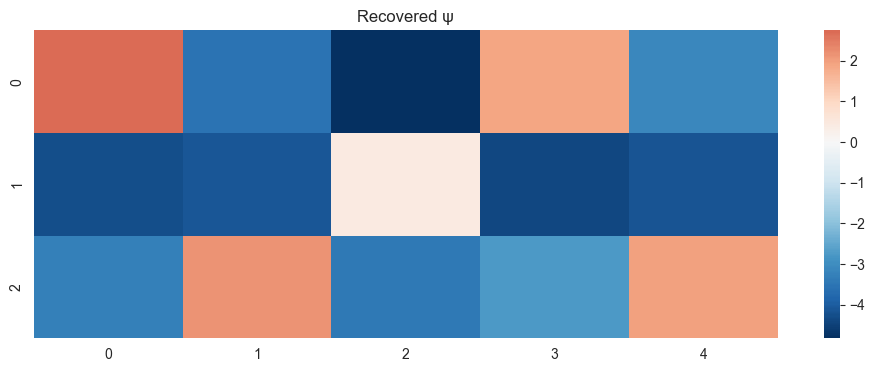

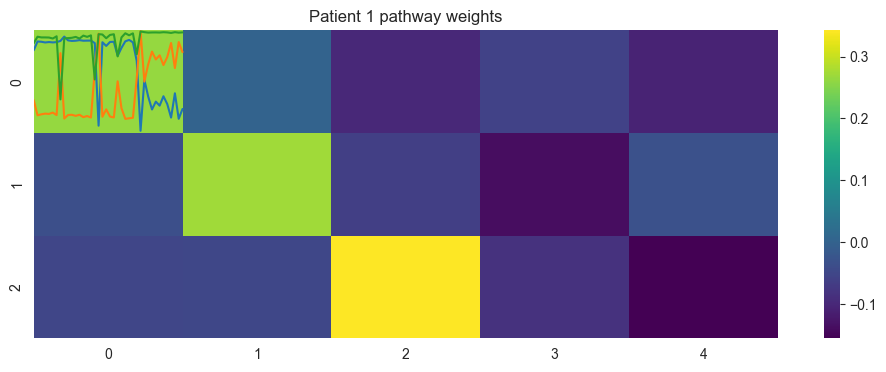

In [29]:
# Compare recovered psi to hot-start and true pathway pattern
plt.figure(figsize=(12,4))
sns.heatmap(results["psi"], cmap="RdBu_r", center=0)
plt.title("Recovered ψ")

plt.figure(figsize=(12,4))
sns.heatmap(simulation["phi"].mean(axis=2), cmap="viridis")
plt.title("True latent signature (avg)")

# Theta trajectories for a patient
patient_idx = 0
plt.plot(dataset.time, results["theta"][patient_idx].T)
plt.title(f"Patient {patient_idx+1} pathway weights")